In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import uuid
import os

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from pathlib import Path
from typing import Dict

In [2]:
def tuple_constructor(loader, node):
    return tuple(loader.construct_sequence(node))

yaml.add_constructor('tag:yaml.org,2002:python/tuple', tuple_constructor)

In [3]:
OUTPUT_DIR = f"{Path.cwd()}/benchmark_output"
MODEL_NAME = "01-ai/Yi-34B-200K"
TP_DIMENSION = 2
TRACES = [
    { 
        "name": "ccdv/arxiv-summarization_filtered",
        "length_provider": "trace",
        "interval_provider": "static",
        "trace_file": "./data/processed_traces/arxiv_summarization_filtered_stats_llama2_tokenizer.csv",
        "num_requests": 128,
        "max_seq_length": 16384
    }
]
SCHEDULERS = [
    { "type": "vllm", "chunk_size": None, "max_batch_size": 256 },
    { "type": "sarathi", "chunk_size": 1536, "max_batch_size": 256},
]

WANDB_PROJECT = "llm-simulator"
WANDB_GROUP = "vllm_generation_stalls_experiments"

In [4]:
def _get_wandb_run_name(
    trace: Dict,
    scheduler: Dict,
    model: str,
    tp_dimension: int,
):
    random_suffix = str(uuid.uuid4()).split("-")[0]
    model = f"{model.split('/')[-1]}_tp_{tp_dimension}"
    trace_name = ""
    if trace['length_provider'] == "uniform":
        trace_name = f"uniform_{trace['max_seq_length']}_pd_ratio_{trace['pd_ratio']}_{trace['interval_provider']}_num_reqs_{trace['num_requests']}"
    else:
        assert trace['length_provider'] == "trace"
        trace_name = f"{trace['name'].split('/')[-1]}_seq{trace['max_seq_length']}_{trace['interval_provider']}_num_reqs_{trace['num_requests']}"
    scheduler = f"{scheduler['type']}_chunk_size_{scheduler['chunk_size']}_batch_size_{scheduler['max_batch_size']}"

    return f"{model}_{trace_name}_{scheduler}_{random_suffix}"

In [5]:
def generate_runs():
    devices = ','.join([str(x) for x in range(TP_DIMENSION)])
    commands = []
    for trace in TRACES:
        for scheduler in SCHEDULERS:
            run_name = _get_wandb_run_name(
                trace=trace,
                scheduler=scheduler,
                model=MODEL_NAME,
                tp_dimension=TP_DIMENSION,
            )
            base_command = (
                f"CUDA_VISIBLE_DEVICES={devices} python sarathi/benchmark/main.py \\\n"
                f"--output_dir {OUTPUT_DIR} \\\n"
                f"--model_name {MODEL_NAME} \\\n"
                f"--model_max_model_len {trace['max_seq_length']} \\\n"
                f"--cluster_num_replicas 1 \\\n"
                f"--model_tensor_parallel_degree {TP_DIMENSION} \\\n"
                f"--model_pipeline_parallel_degree 1 \\\n"
                f"--request_generator_provider synthetic \\\n"
                f"--synthetic_request_generator_interval_provider static \\\n"
                f"--synthetic_request_generator_num_requests {trace['num_requests']} \\\n"
                f"--metrics_store_keep_individual_batch_metrics true \\\n"
                f"--metrics_store_enable_op_level_metrics false \\\n"
                f"--metrics_store_wandb_project {WANDB_PROJECT} \\\n"
                f"--metrics_store_wandb_group {WANDB_GROUP} \\\n"
                f"--metrics_store_wandb_run_name {run_name} \\\n"

            )
            if trace['length_provider'] == "uniform":
                base_command += (
                    f"--synthetic_request_generator_length_provider uniform \\\n"
                    f"--request_generator_max_tokens {trace['max_seq_length']} \\\n"
                    f"--synthetic_request_generator_min_tokens {trace['max_seq_length']} \\\n"
                    f"--synthetic_request_generator_prefill_to_decode_ratio {trace['pd_ratio']} \\\n"
                )
            else:
                base_command += (
                    f"--synthetic_request_generator_length_provider trace \\\n"
                    f"--trace_request_length_generator_trace_file {trace['trace_file']} \\\n"
                    f"--trace_request_length_generator_max_tokens {trace['max_seq_length']} \\\n"
                    f"--trace_request_length_generator_prefill_scale_factor 1 \\\n"
                    f"--trace_request_length_generator_decode_scale_factor 1 \\\n"
                )

            if scheduler['type'] == "vllm":
                command = base_command + (
                    f"--replica_scheduler_provider vllm \\\n"
                    f"--replica_scheduler_max_batch_size {scheduler['max_batch_size']} \\\n"
                    f"--vllm_scheduler_max_tokens_in_batch {trace['max_seq_length']} \n"
                )
            elif scheduler['type'] == "sarathi":
                command = base_command + (
                    f"--replica_scheduler_provider sarathi \\\n"
                    f"--replica_scheduler_max_batch_size {scheduler['max_batch_size']} \\\n"
                    f"--sarathi_scheduler_chunk_size {scheduler['chunk_size']} \\\n"
                    f"--sarathi_scheduler_enable_dynamic_chunking_schedule false\n"
                )
            else:
                assert scheduler['type'] == "orca"
                command = base_command + (
                    f"--replica_scheduler_provider orca \\\n"
                    f"--replica_scheduler_max_batch_size {scheduler['max_batch_size']} \n"
                )

            commands.append(command)
    with open(f"generation_stalls.sh", "w") as f:
        f.write("#!/bin/bash\n")
        f.write("set -x\n")
        for command in commands:
            f.write(command + "\n")


In [6]:
def _get_run_directories():
    rootdir = Path(OUTPUT_DIR)
    subdirectory_list = [
        directory for directory in rootdir.iterdir() if directory.is_dir()
    ]
    return subdirectory_list

In [7]:
def _get_decode_completion_times():
    run_directories = _get_run_directories()
    run_directories.sort()

    datapoints = []

    yaml.SafeLoader.add_constructor('tag:yaml.org,2002:python/tuple', tuple_constructor)
    for run_dir in run_directories:
        try:
            with open(f"{run_dir}/replica_0/config.yml", "r") as config_file, open(
                f"{run_dir}/benchmark_config.yml", "r"
            ) as benchmark_config_file, open(
                f"{run_dir}/replica_0/plots/decode_completion_time_series.csv", "r"
            ) as decode_completion_times_file:
                config = yaml.safe_load(config_file)
                benchmark_config = yaml.safe_load(benchmark_config_file)
                decode_completion_times = pd.read_csv(decode_completion_times_file)

                scheduler = config["scheduler_type"]
                if config["scheduler_type"] == "sarathi":
                    scheduler += f"_{config['chunk_size']}"
                
                decode_completion_times["name"] = scheduler
                datapoints.append(decode_completion_times)
        except FileNotFoundError as e:
            print(f"WARN: Skipping {run_dir} due to {e}")
    
    return pd.concat(datapoints)

In [8]:
def plot():
    df = _get_decode_completion_times()
    # Group the data by the 'id' column
    groups = df.groupby("name")

    # Create a new figure
    fig, ax = plt.subplots()

    # Iterate over each group
    for name, group in groups:
        # Plot the time series for this group
        color = "chocolate" if name == "vllm" else "green"
        ax.plot(group["Time (sec)"],
                group["decode_completion"],
                label=name,
                linewidth=1.5,
                color=color)

    # Add a legend
    ax.legend(loc="upper left", fontsize=22)

    # Label the x and y axes
    ax.set_xlabel("Time (s)", fontweight="bold", fontsize=20)
    ax.set_ylabel("# output tokens", fontweight="bold", fontsize=22)

    # Add gridlines
    ax.grid(True, linestyle="--")

    plt.yticks(fontsize=12)
    plt.xticks(fontsize=11)

    ylabels = ["{:,.0f}".format(y) + "K" for y in ax.get_yticks() / 1000]
    ax.set_yticklabels(ylabels)

    # Create a set of inset Axes: these should fill the bounding box allocated to them.
    ax_sub = ax.inset_axes([0.625, 0.125, 0.33, 0.33])
    for name, group in groups:
        color = "chocolate" if name == "vllm" else "green"
        ax_sub.plot(group["Time (sec)"],
                    group["decode_completion"],
                    label=name,
                    marker=".",
                    color=color)
    ax_sub.set_xlim(225, 275)  # specify the limits for x-axis
    ax_sub.set_ylim(10000, 12500)  # specify the limits for y-axis

    # Remove the y-axis ticks from the zoomed subplot
    ax_sub.yaxis.set_ticks([])

    # Add lines connecting the zoomed subplot to the main plot
    mark_inset(ax, ax_sub, loc1=3, loc2=1, fc="none", ec="0.5")

    # Show the plot
    plt.savefig("yi-arxiv.pdf")
    plt.show()

In [9]:
generate_runs()

/tmp/ipykernel_966006/1837036611.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


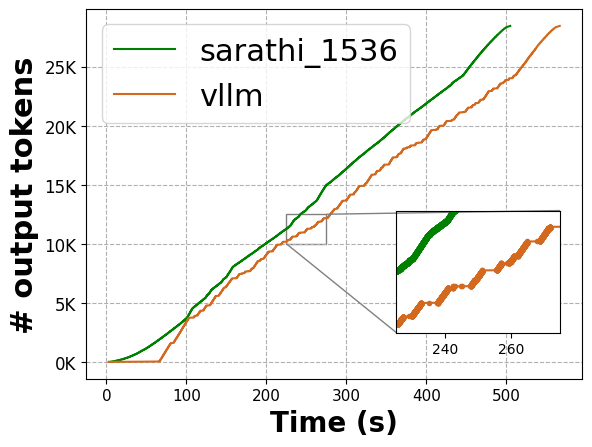

In [10]:
plot()